# Analysis of the available time-series 

In [1]:
from statsmodels.tsa.stattools import grangercausalitytests
from matplotlib.collections import PatchCollection
from itertools import permutations
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import string
import math
plt.style.use("ggplot")

In [2]:
# Food Consumption Score (FCS/FCG) and relative FCGs values already processed (see notebook FCS in the Food Consumption Score folder).
df = pd.read_excel("../Food Consumption Score/mVam_FoodConsumptionScore_processed.xlsx")
df.head()

,Country,AdminStrata,Datetime,Mean,Median,Poor,Borderline,Acceptable,Metric
0,Democratic Republic of the Congo,Buleusa,2016-12-31,33.20,31.0,33.33,53.33,13.33,86.66
1,Democratic Republic of the Congo,Buleusa,2017-01-31,NaN,NaN,NaN,NaN,NaN,NaN
2,Democratic Republic of the Congo,Buleusa,2017-02-28,NaN,NaN,NaN,NaN,NaN,NaN
3,Democratic Republic of the Congo,Buleusa,2017-03-31,21.55,21.0,92.11,7.90,0.00,100.01
4,Democratic Republic of the Congo,Eringeti,2016-11-30,29.64,30.0,37.74,60.38,1.89,98.12


In [3]:
# Find all the continuous temporal blocks series at AdminStrata level (monthly based).
def continuous_timeseries(group):
    group.set_index("Datetime", inplace = True) 
    agged = group.Metric.groupby(group.Metric.isnull().cumsum()).agg(Start = pd.Series.first_valid_index, 
                                                                     Stop = pd.Series.last_valid_index, 
                                                                     Length = "count").dropna()
    return agged

agged = df.groupby(["Country", "AdminStrata"]).apply(continuous_timeseries)
agged.reset_index(inplace = True)
agged.drop("Metric", axis = 1, inplace = True)
agged.head()

,Country,AdminStrata,Start,Stop,Length
0,Democratic Republic of the Congo,Buleusa,2016-12-31,2016-12-31,1
1,Democratic Republic of the Congo,Buleusa,2017-03-31,2017-03-31,1
2,Democratic Republic of the Congo,Eringeti,2016-11-30,2016-12-31,2
3,Democratic Republic of the Congo,Eringeti,2017-03-31,2017-03-31,1
4,Democratic Republic of the Congo,Eringeti,2017-05-31,2017-05-31,1


In [4]:
# Find the total points for each AdminStrata of each country.
agged.groupby(["Country", "AdminStrata"])["Length"].sum().to_frame().head()

Length
Country                          AdminStrata        
Democratic Republic of the Congo Buleusa           2
                                 Eringeti          4
                                 Kalinga           3
                                 Kalunga           4
                                 Kasai            20

In [5]:
# Find the max length of time series (AdminStrata level) without interruption for each country.
max_ts = agged.iloc[agged.groupby(["Country"]).apply(lambda x: x["Length"].idxmax())]
max_ts.reset_index(inplace = True, drop = True)
max_ts.head()

,Country,AdminStrata,Start,Stop,Length
0,Democratic Republic of the Congo,Kasai,2018-03-31,2019-05-31,15
1,Guinea,Boke,2016-12-31,2016-12-31,1
2,Iraq,Baghdad,2015-03-31,2016-02-29,12
3,Lesotho,Berea-Butha Buthe-Leribe,2016-11-30,2017-06-30,8
4,Malawi,Blantyre-Mwanza-Neno-Balaka,2017-02-28,2017-05-31,4


## Example: Yemen country

In [6]:
sub_df = df[df.Country == "Yemen"]
sub_df.reset_index(inplace = True, drop = True)
sub_df.head()

,Country,AdminStrata,Datetime,Mean,Median,Poor,Borderline,Acceptable,Metric
0,Yemen,Abyan,2015-09-30,49.93,50.00,12.68,21.42,65.90,34.10
1,Yemen,Abyan,2015-10-31,NaN,NaN,NaN,NaN,NaN,NaN
2,Yemen,Abyan,2015-11-30,49.54,46.16,22.49,23.70,53.82,46.19
3,Yemen,Abyan,2015-12-31,52.80,52.00,13.19,22.92,63.89,36.11
4,Yemen,Abyan,2016-01-31,48.00,50.00,28.31,15.13,56.56,43.44


In [7]:
# Fill the small gaps of the time-series using a linear interpolation.
sub_df_interpolate = sub_df.interpolate(method = "linear").copy()
sub_df_interpolate.head()

,Country,AdminStrata,Datetime,Mean,Median,Poor,Borderline,Acceptable,Metric
0,Yemen,Abyan,2015-09-30,49.930,50.00,12.680,21.42,65.90,34.100
1,Yemen,Abyan,2015-10-31,49.735,48.08,17.585,22.56,59.86,40.145
2,Yemen,Abyan,2015-11-30,49.540,46.16,22.490,23.70,53.82,46.190
3,Yemen,Abyan,2015-12-31,52.800,52.00,13.190,22.92,63.89,36.110
4,Yemen,Abyan,2016-01-31,48.000,50.00,28.310,15.13,56.56,43.440


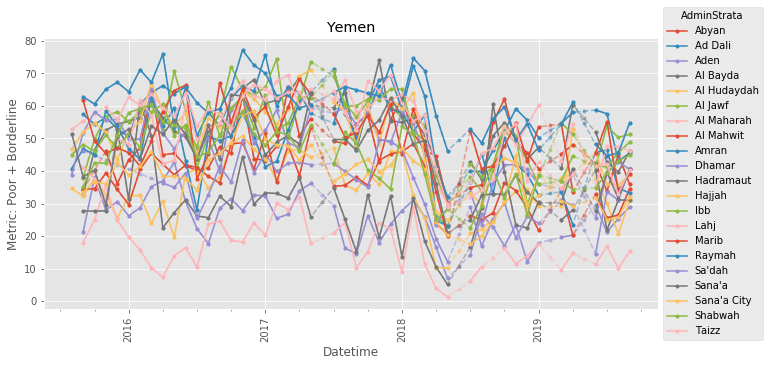

In [8]:
# Show using the white color the points obtained through the interpolation.
f = plt.figure(figsize = (11, 5))
plt.title("Yemen", color = "black")
# Add a prefix in order to ignore labels in the legend.
sub_df_interpolate.AdminStrata = "_" + sub_df_interpolate.AdminStrata
sub_df_interpolate.groupby(["Datetime", "AdminStrata"]).mean()["Metric"].unstack().plot(ax = f.gca(), style = ".--", alpha = 0.5, legend = None)
sub_df.groupby(["Datetime", "AdminStrata"]).mean()["Metric"].unstack().plot(ax = f.gca(), style = ".-", legend = True)
plt.legend(title = "AdminStrata", loc = "center left", bbox_to_anchor = (1.0, 0.5))
plt.ylabel("Metric: Poor + Borderline")
plt.xticks(rotation = 90)
plt.autoscale()
plt.show()

In [9]:
# Visualize the data to fed the machine learning algorithm.
sub_df_interpolate = sub_df.interpolate(method = "linear").copy()
ts = sub_df_interpolate.groupby(["Datetime", "AdminStrata"]).mean()["Metric"].unstack()
# Delete NaN values in order to have equal time-series range.
ts.dropna(inplace = True)
ts.head()

AdminStrata,Abyan,Ad Dali,Aden,Al Bayda,Al Hudaydah,Al Jawf,Al Maharah,Al Mahwit,Amran,Dhamar,...,Hajjah,Ibb,Lahj,Marib,Raymah,Sa'dah,Sana'a,Sana'a City,Shabwah,Taizz
Datetime,,,,,,,,,,,,,,,,,,,,,
2015-09-30,34.100,57.43,21.22,32.76,32.28,37.97,18.00,34.38,46.82,51.76,...,52.04,48.10,41.31,61.71,62.84,46.230000,38.25,33.43,35.22,55.37
2015-10-31,40.145,54.33,38.02,46.39,37.67,49.74,25.00,34.56,45.05,58.15,...,54.73,46.12,37.69,49.25,60.59,44.811429,40.24,36.76,42.42,57.60
2015-11-30,46.190,56.44,27.95,52.56,32.65,56.74,35.56,39.38,58.51,55.58,...,51.95,51.04,30.62,45.39,65.15,43.392857,29.66,35.96,42.41,59.83
2015-12-31,36.110,53.04,30.60,54.37,25.54,58.22,24.82,34.31,53.84,55.84,...,43.49,47.02,50.17,47.12,67.28,41.974286,50.51,42.51,51.00,55.53
2016-01-31,43.440,50.44,26.24,55.33,32.19,55.17,19.78,29.67,46.88,49.89,...,52.10,51.67,48.03,45.62,64.38,40.555714,52.91,38.82,57.95,62.71


In [10]:
print("The lengths (monthly based) of the time-series are:", len(ts))

The lengths (monthly based) of the time-series are: 49


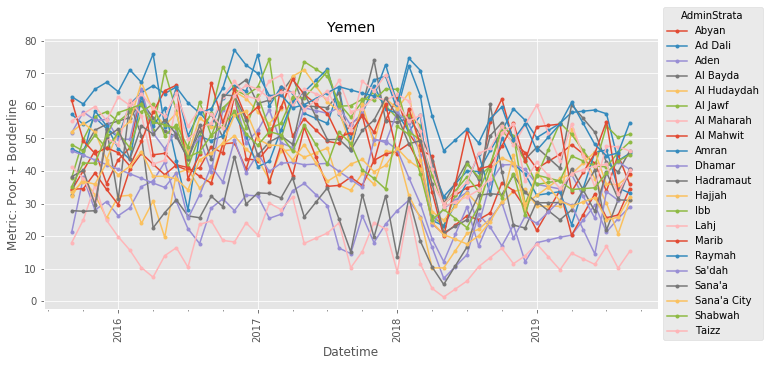

In [11]:
# Show the time-series to use.
f = plt.figure(figsize = (11, 5))
plt.title("Yemen", color = "black")
ts.plot(ax = f.gca(), style = ".-")
plt.legend(title = "AdminStrata", loc = "center left", bbox_to_anchor = (1.0, 0.5))
plt.ylabel("Metric: Poor + Borderline")
plt.xticks(rotation = 90)
plt.autoscale()
plt.show()

### Paper: The dynamics of information-driven coordination phenomena: A transfer entropy analysis

Link to the paper: https://advances.sciencemag.org/content/2/4/e1501158.abstract (see also the related Supplementary Materials for all technical details)

Link to other related paper: https://www.researchgate.net/publication/51394868_Symbolic_Transfer_Entropy 

Link to a book useful for deriving the opportune probabilities (joint and conditional): https://books.google.it/books?id=BVAhFY3uBbcC&pg=PA14&lpg=PA14&dq=joint+probability+that+a+word+follows+another&source=bl&ots=yUzYjK_IiQ&sig=ACfU3U0imibwHgnsV92j2e7KwWBEUo3zHg&hl=it&sa=X&ved=2ahUKEwiXkfblqefmAhWM-KQKHcueAKMQ6AEwCnoECAcQAQ#v=onepage&q=joint%20probability%20that%20a%20word%20follows%20another&f=false

Let $x_i = x(i)$ and $y_i = y(i)$, $i = 1, ..., N$, denote sequences of observations from systems $X$ and $Y$ (time-series). *Transfer entropy* incorporates time dependence by relating previous samples $x_i$ and $y_i$ to predict the next value $x_{i+1}$, and quantifies the deviation from the generalized Markov property, $p(x_{i+1}|x_i, y_i) = p(x_{i+1}|x_i)$,where $p$ denotes the transition probability density. If there is no deviation from the generalized Markov property, $Y$ has no influence on $X$. Transfer entropy, which is formulated as Kullback-Leibler entropy between $p(x_{i+1}|x_i, y_i)$ and $p(x_{i+1}|x_i)$, quantifies the incorrectness of this assumption, and is explicitly non-symmetric under the exchange of $x_i$ and $y_i$. We suggest to estimate transfer entropy by adopting a technique of symbolization, which has already been introduced with the concept of permutation entropy (see next section with the Giovanni Petri's paper). An important feature of symbolic approaches is that they discount the relative magnitude of each time series; this is important in our case because different geographical units can differ largely in population density. This approach is named **Symbolic Transfer Entropy** (STE). 

STE quantifies the directional flow of information between two time series, $X$ and $Y$, by first categorizing the signals in a small set of symbols or alphabet. Let's see this procedure to symbolic conversion:

In [12]:
# Embedding dimension with which obtain symbol series: 3 <= m <= 7.
m = 3

In [13]:
# Get the pattern to permutate based on the value m.
pattern = np.arange(m) + 1
# Get all permutations/patterns.
patterns = list(permutations(pattern))
# Get a list of indices linked to symbols (alphabet) corresponding to each pattern.
symbols = list(string.ascii_uppercase)
dict_pattern_symbol = dict()
for i in range(len(patterns)):
    dict_pattern_symbol[patterns[i]] = symbols[i]
print(dict_pattern_symbol)

{(1, 2, 3): 'A', (1, 3, 2): 'B', (2, 1, 3): 'C', (2, 3, 1): 'D', (3, 1, 2): 'E', (3, 2, 1): 'F'}


In [14]:
# Due to some trouble with pandas function, we'll use integer instead of letters (A is 0, B is 1 and so on).
dict_pattern_index = dict()
for i in range(len(patterns)):
    dict_pattern_index[patterns[i]] = i
print(dict_pattern_index)

{(1, 2, 3): 0, (1, 3, 2): 1, (2, 1, 3): 2, (2, 3, 1): 3, (3, 1, 2): 4, (3, 2, 1): 5}


In [15]:
def symbolized_sample(pattern):
    sorted_indices = tuple(np.argsort(pattern) + 1)
    symbol = dict_pattern_index[sorted_indices]
    return symbol

In [16]:
ts_symb = ts.rolling(m).apply(symbolized_sample, raw = True).dropna().reset_index(drop = True)
#ts_symb = ts_symb.applymap(lambda x: symbols[int(x)]) # Get the corresponding symbol as the algorithm would like to (only for visualization).
ts_symb.head()

AdminStrata,Abyan,Ad Dali,Aden,Al Bayda,Al Hudaydah,Al Jawf,Al Maharah,Al Mahwit,Amran,Dhamar,...,Hajjah,Ibb,Lahj,Marib,Raymah,Sa'dah,Sana'a,Sana'a City,Shabwah,Taizz
0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,...,4.0,2.0,5.0,5.0,2.0,5.0,4.0,1.0,1.0,0.0
1,4.0,4.0,3.0,0.0,5.0,0.0,4.0,4.0,1.0,3.0,...,5.0,1.0,2.0,3.0,0.0,5.0,2.0,2.0,2.0,4.0
2,3.0,5.0,4.0,0.0,3.0,4.0,5.0,5.0,5.0,4.0,...,2.0,2.0,1.0,1.0,4.0,5.0,0.0,1.0,0.0,2.0
3,0.0,2.0,3.0,0.0,0.0,3.0,5.0,2.0,5.0,5.0,...,0.0,1.0,2.0,5.0,2.0,5.0,4.0,3.0,0.0,1.0
4,0.0,0.0,0.0,0.0,4.0,0.0,5.0,0.0,2.0,2.0,...,0.0,2.0,1.0,2.0,1.0,5.0,2.0,0.0,0.0,2.0


Now, we can obtain the pairwise STE computing the joint and conditional probabilities of the sequence indices from the relative frequency of symbols in each sequence, $\hat{X}$ and $\hat{Y}$, as:

$$ T_{Y, X} = \sum p(\hat{x}_{i+1}, \hat{x}_{i}, \hat{y}_{i}) log_2(\frac{p(\hat{x}_{i+1}| \hat{x}_{i}, \hat{y}_{i})}{p(\hat{x}_{i+1}| \hat{x}_{i})})$$

where the sum runs over each symbol in the sequence.


In [17]:
def STE_XY(X, Y):
    N = len(X)
    T_XY = 0
    for i in range(N - 1):
        yi = (Y == Y[i]).astype(int)
        yip1 = np.roll((Y == Y[i + 1]).astype(int), -1) # Shift one forward.
        xi = (X == X[i]).astype(int)
        
        prob1 = (yi + yip1 + xi == 3).astype(int)[0:N].sum()/(N)
        prob2 = ((yi + yip1 + xi == 3).astype(int)[0:N].sum()/(N)) / ((yi + xi == 2).astype(int)[0:N].sum()/(N))
        prob3 = ((yi + yip1 == 2).astype(int)[0:N].sum()/(N)) / (yi[0:N].sum()/(N)) 
        
        T_XY += prob1 * math.log2(prob2 / prob3)
        
    return T_XY

Let's compute the STE for all the couples (AdminStrata) in the dataset, getting the matrix $T$.

In [18]:
# Building this method in order to overcome the limitation of 'corr' pandas function.
T = np.tril(ts_symb.corr(method = STE_XY).values) + np.triu(ts_symb.corr(method = lambda *args : STE_XY(*args[::-1])).values)
np.fill_diagonal(T, ts_symb.apply(lambda x: STE_XY(x, x)))
T = pd.DataFrame(T, index = ts_symb.columns, columns = ts_symb.columns)
T.head()

AdminStrata,Abyan,Ad Dali,Aden,Al Bayda,Al Hudaydah,Al Jawf,Al Maharah,Al Mahwit,Amran,Dhamar,...,Hajjah,Ibb,Lahj,Marib,Raymah,Sa'dah,Sana'a,Sana'a City,Shabwah,Taizz
AdminStrata,,,,,,,,,,,,,,,,,,,,,
Abyan,0.000000,1.297412,0.759634,0.852238,1.194261,1.178216,0.811051,1.198286,1.351592,1.155948,...,0.634618,0.975191,1.026797,0.549883,0.853509,1.227637,1.301435,1.210129,0.870352,1.209752
Ad Dali,1.333598,0.000000,1.151204,0.785835,1.196810,1.203923,0.966695,0.710611,1.079893,1.482579,...,1.120223,0.981206,0.919725,0.649529,0.888112,0.930572,1.066393,1.085307,1.055963,0.879022
Aden,1.179296,1.274756,0.000000,1.095436,0.990372,0.936626,0.825312,1.110736,0.740120,0.875428,...,1.134427,1.062463,0.850752,1.023341,0.655299,0.876040,1.100412,1.062397,1.192597,1.081068
Al Bayda,0.849992,1.243051,1.093815,0.000000,0.921074,0.856934,0.801272,0.712059,1.029102,0.903868,...,1.115745,1.111475,0.895164,1.556683,0.813104,1.458937,0.925191,1.162619,1.057242,0.809116
Al Hudaydah,1.489891,0.891524,1.029479,0.727534,0.000000,1.335767,0.748846,0.960813,1.177380,1.029687,...,0.740604,1.082939,1.109591,1.009242,0.853501,0.687633,1.118703,0.915938,0.895634,1.245866


The matrix $T$ contains pairwise information about how each component in the system controls (or is controlled by) the others. The matrix is asymmetric. The directionality is crucial and denotes that the geographic area $x$ (on x-axis) can exert some driving on area $y$ (y-axis) and, at the same time, $y$ might exert some driving on $x$.

(21.0, 0.0)

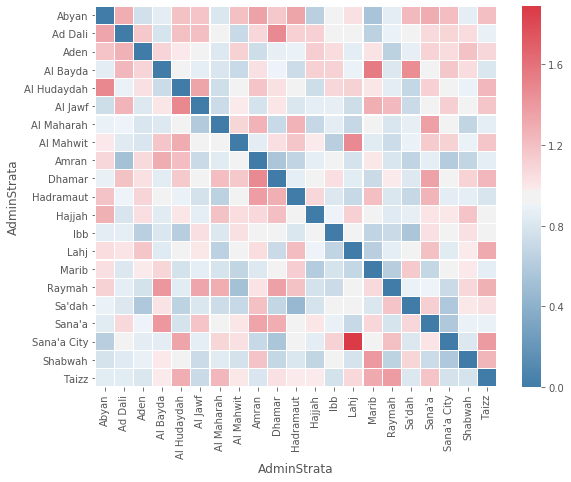

In [19]:
fig = plt.figure(figsize = (9, 7))
# Colors.
cmap = sns.diverging_palette(240, 10, as_cmap = True)
# Plotting the heatmap.
ax = sns.heatmap(T, linewidths = .1, cmap = cmap, xticklabels = T.columns, yticklabels = T.columns)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

It is convenient to define the directionality index $T_{X, Y}^{S} = T_{Y,X} - T_{X, Y}$, which measures the balance of information flow in both directions. This index quantifies the dominant direction of information flow and is expected to have positive values for undirectional couplings with $x$ (x-axis) as driver and negative values if $y$ (y-axis) is driving $x$. For symmetric bidirectional couplings, we expect $T_{X, Y}^{S}$ to be null.

In [20]:
T_s = (T.values.transpose() - T.values).transpose()
T_s = pd.DataFrame(T_s, index = ts_symb.columns, columns = ts_symb.columns)

(21.0, 0.0)

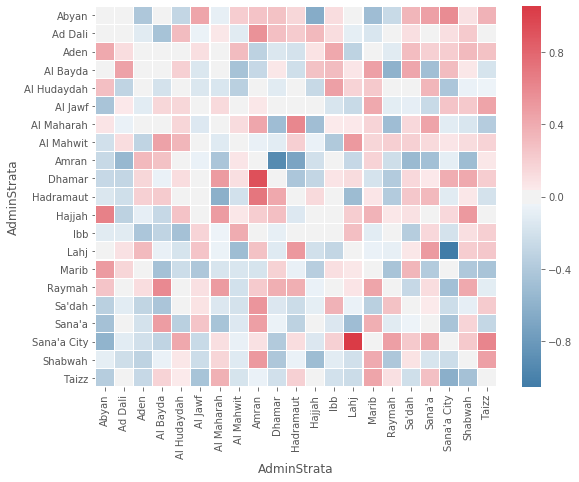

In [21]:
fig = plt.figure(figsize = (9, 7))
# Colors.
cmap = sns.diverging_palette(240, 10, as_cmap = True)
# Plotting the heatmap.
ax = sns.heatmap(T_s, linewidths = .1, cmap = cmap, center = 0, xticklabels = T_s.columns, yticklabels = T_s.columns)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

We show the quantity $\sum_Y T_{X, Y}^{S}$ that provides the information flow balance of each specific geographical area.

(21.0, 0.0)

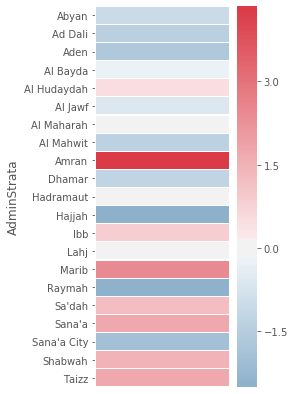

In [22]:
fig = plt.figure(figsize = (3, 7))
# Colors.
cmap = sns.diverging_palette(240, 10, as_cmap = True)
# Plotting the heatmap.
ax = sns.heatmap(T_s.sum().to_frame(), cmap = cmap, linewidths = .1, center = 0, xticklabels = "")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

The transition between centralized and decentralized information-transfer scenarios can be visually inspected with a convenient sorting of the rows and columns of the $T$ matrix, ranking each subunit of the system. The rank for a subunit $x$ is
assigned according to the number of times $x$ is dominant over the rest of the subunits.

In [23]:
ranked_names = T_s.apply(lambda x: x > 0).sum().sort_values().keys()

In [24]:
T_r = T.reindex(ranked_names, axis = 1).reindex(ranked_names, axis = 0)

Once the ranking is settled, any $T_{x, y} < \frac{1}{2} T^{max}_{x, y}$ is set to 0 to improve the visual understanding of the figure.

In [25]:
def order_disorder(x):
    if x < (1/2)*T.values.max():
        return 0
    else:
        return x
    
T_d = T_r.applymap(order_disorder)

(21.0, 0.0)

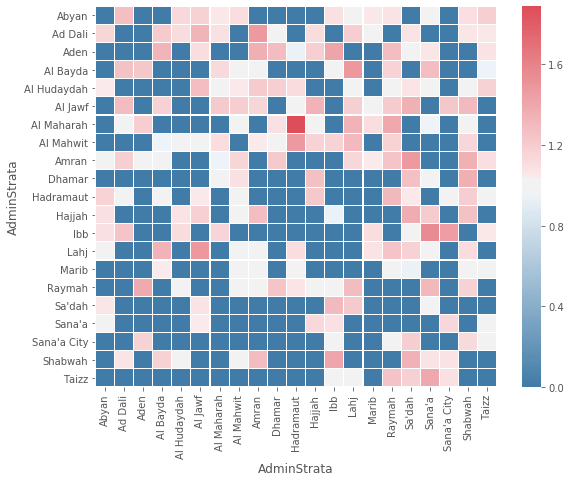

In [26]:
fig = plt.figure(figsize = (9, 7))
# Colors.
cmap = sns.diverging_palette(240, 10, as_cmap = True)
# Plotting the heatmap.
ax = sns.heatmap(T_d, linewidths = .1, cmap = cmap, center = 1, xticklabels = T_s.columns, yticklabels = T_s.columns)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

If $\theta << 1$ a few subunits have a dominant directional coupling to the rest of the system; if $\theta \sim 1$ the systems
approach the onset date of the collective event, identifying a regime in which the couplings indicate the existence of collective phenomena where all subunits mutually affect each other.

In [27]:
theta = np.tril(T).sum() / np.triu(T).sum()
theta

0.994334031223412

#### Complete analysis

In the paper, several time subdivisions have been analyzed starting from the time-series (STE is not measured over time series taken as a whole): suppose to have a sliding windows long $w$ (for example, $w$ = 1 day), then for each day different time-series are built for each subunits varying the time step $\Delta t$ (from 1 to 120 minutes, with increases of 5 to 15 minutes depending on the datasets). To select the optimal sampling rate, we consider all possible pairs $(X, Y)$, with the same $\Delta t$, of geographical units and measure the total STE in the system $T = \sum_{XY} T_{X,Y}$ as a function of $\Delta t$. The $\Delta t$ with the highest $T$ defines the time scale $\tau$ and notes it at that day. I scroll the window forward one day (without overlap) and proceed with this method.

Our time-series not have this freedom regarding the time dependence, so this approach it's difficult to be applied.

We semplify this procedure fractionizing the time-series into sub-time series of length $w$, sliding a window with stride $1$. For each of these sub-time series, we apply the previous method and we compute the quantity $\sum_Y T_{X, Y}^{S}$ for each AdminStrata.

Let's see this in practice:

In [28]:
# Set the length of the sliding window.
w = 12 # months

In [29]:
sum_TY = pd.DataFrame([], columns = ts.columns)
Mean = pd.DataFrame([], columns = ts.columns)
for i in range(len(ts) - w):
    # Get the slice of dataframe of length w.
    sub_ts = ts[i:i + w]
    # Apply the previous method of the Symbolic Transfer Entropy to the current slice of dataframe.
    sub_ts_symb = sub_ts.rolling(m).apply(symbolized_sample, raw = True).dropna().reset_index(drop = True)    
    T = np.tril(sub_ts_symb.corr(method = STE_XY).values) + np.triu(sub_ts_symb.corr(method = lambda *args : STE_XY(*args[::-1])).values)
    np.fill_diagonal(T, sub_ts_symb.apply(lambda x: STE_XY(x, x)))
    T = pd.DataFrame(T, index = sub_ts_symb.columns, columns = sub_ts_symb.columns)
    T_s = (T.values.transpose() - T.values).transpose()
    T_s = pd.DataFrame(T_s, index = sub_ts_symb.columns, columns = sub_ts_symb.columns)
    # Compute the sum over Y.
    T_s_sum = T_s.sum()
    T_s_sum.name = sub_ts.index[-1] # Set the last month of the 12 months as index. 
    # Compute the mean of the metric happens in that window of length w.
    mean = sub_ts.mean()
    mean.name = sub_ts.index[-1] # Set the last month of the 12 months as index. 
    
    sum_TY = sum_TY.append(T_s_sum)
    Mean = Mean.append(mean)

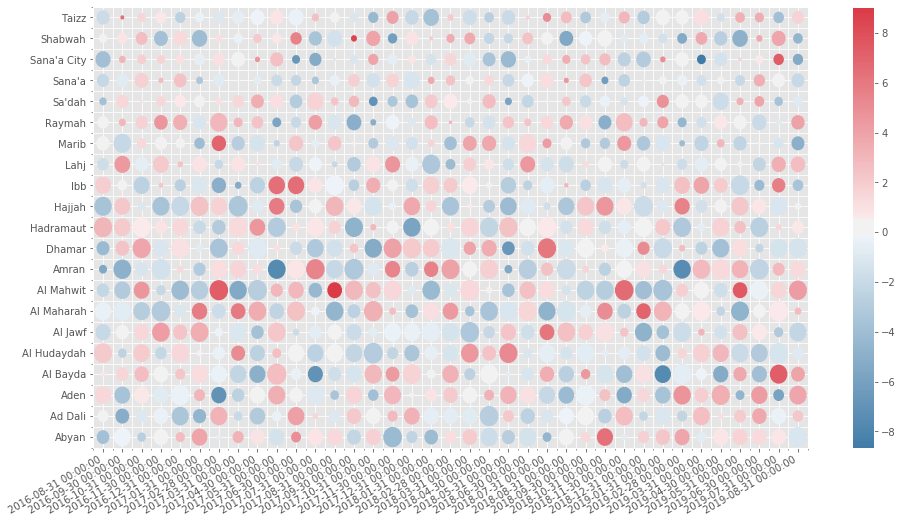

In [30]:
ylabels = sum_TY.columns
xlabels = sum_TY.index

M = len(xlabels)
N = len(ylabels)

x, y = np.meshgrid(np.arange(M), np.arange(N)) 
s = Mean.values
c = sum_TY.values

fig, ax = plt.subplots(figsize = (16, 9))

R = s/s.max()/2
circles = [plt.Circle((j,i), radius = r) for r, j, i in zip(R.flat, x.flat, y.flat)]
# Colors.
cmap = sns.diverging_palette(240, 10, as_cmap = True)
col = PatchCollection(circles, array = c.flatten(), cmap = cmap)
ax.add_collection(col)

ax.set(xticks = np.arange(M), yticks = np.arange(N),
       xticklabels = xlabels, yticklabels = ylabels)
ax.set_xticks(np.arange(M+1) - 0.5, minor = True)
ax.set_yticks(np.arange(N+1) - 0.5, minor = True)
ax.grid(which = "minor")

fig.autofmt_xdate()
fig.colorbar(col)
plt.show()

The color goes from dark blue to dark red (white corresponds to null driving), with the former standing for negative values of $\sum_Y T_{X, Y}^{S}$ (that is, driven locations) and the latter corresponding to positive information flow balances (that is, drivers). The size of the circles is proportional to the mean of the metric (poor + borderline) happened from the location at
that month.

(21.0, 0.0)

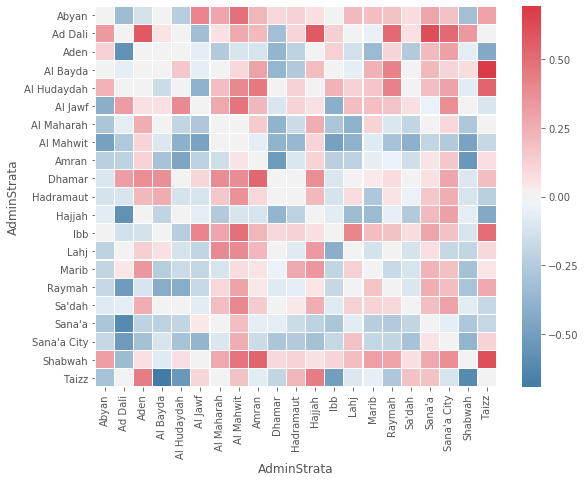

In [31]:
# Plot the T_s matrix related to the last 12 months.
fig = plt.figure(figsize = (9, 7))
# Colors.
cmap = sns.diverging_palette(240, 10, as_cmap = True)
# Plotting the heatmap.
ax = sns.heatmap(T_s, linewidths = .1, cmap = cmap, center = 0, xticklabels = T_s.columns, yticklabels = T_s.columns)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

### Paper: On the predictability of infectious disease outbreaks

Link to the paper: https://www.nature.com/articles/s41467-019-08616-0 

The logic/methodology to achieve to the permutation entropy of a time-series is analogous to the Symbolic Transfer Entropy: generating a symbolic alphabet.

In [32]:
ts_symb.head()

AdminStrata,Abyan,Ad Dali,Aden,Al Bayda,Al Hudaydah,Al Jawf,Al Maharah,Al Mahwit,Amran,Dhamar,...,Hajjah,Ibb,Lahj,Marib,Raymah,Sa'dah,Sana'a,Sana'a City,Shabwah,Taizz
0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,...,4.0,2.0,5.0,5.0,2.0,5.0,4.0,1.0,1.0,0.0
1,4.0,4.0,3.0,0.0,5.0,0.0,4.0,4.0,1.0,3.0,...,5.0,1.0,2.0,3.0,0.0,5.0,2.0,2.0,2.0,4.0
2,3.0,5.0,4.0,0.0,3.0,4.0,5.0,5.0,5.0,4.0,...,2.0,2.0,1.0,1.0,4.0,5.0,0.0,1.0,0.0,2.0
3,0.0,2.0,3.0,0.0,0.0,3.0,5.0,2.0,5.0,5.0,...,0.0,1.0,2.0,5.0,2.0,5.0,4.0,3.0,0.0,1.0
4,0.0,0.0,0.0,0.0,4.0,0.0,5.0,0.0,2.0,2.0,...,0.0,2.0,1.0,2.0,1.0,5.0,2.0,0.0,0.0,2.0


The **Permutation Entropy** (PE) of a time-series $\{x_t\}$ is then given by the Shannon entropy on the permutation orders (alphabet), that is: 

$$H^p(\{x_t\}) = - \sum_\pi p_{\pi} log(p_{\pi})$$ 

where $p_{\pi}$ is the probability of encountering the pattern associated with permutation $\pi$. Finally, the metric used is the predictability defined as $\chi = 1 - H^p$.

The closer to 1 the $\chi$ is, the more regular and more deterministic the time series is. Contrarily, the smaller $\chi$ is, the more noisy and random the time series is.

In [33]:
def chi(x):
    Hp = 0
    value_counts = x[x.name].value_counts()
    p_pi = value_counts.divide(len(x))
    for p in p_pi:
        Hp += p * math.log(p)
    Hp = -Hp
    Hp = Hp/math.log(math.factorial(m))
    return 1 - Hp

In [34]:
ts_symb.groupby(axis = 1, level = 0).apply(chi).reset_index(name = "X")

,AdminStrata,X
0,Abyan,0.045267
1,Ad Dali,0.017434
2,Aden,0.067986
3,Al Bayda,0.056429
4,Al Hudaydah,0.053955
5,Al Jawf,0.033114
6,Al Maharah,0.024033
7,Al Mahwit,0.018922
8,Amran,0.033114
9,Dhamar,0.025521


N.B. In the paper, several time subdivisions have been considered (not just the whole time series) and each of them studied through the previous method.

### Granger Casuality test

Granger causality test is used to determine if one time-series will be useful to forecast another. It is based on the idea that if $X$ (time-series) "Granger" causes $Y$ (other time-series), then the forecast of $Y$ based on previous values of $Y$ AND the previous values of $X$ should outperform the forecast of $Y$ based on previous values of $Y$ alone.

The simplest test of Granger Causality requires estimating the following two regression equations:

$$Y_t = a_0 + a_1 Y_{t-1} + ..... + a_p Y_{t-p} + b_1 X_{t-1} + ..... + b_p X_{t-p} + u_t$$ 

$$X_t = c_0 + c_1 X_{t-1} + ..... + c_p X_{t-p} + d_1 Y_{t-1} + ..... + d_p Y_{t-p} + v_t$$

where $p$ is the number of the time lags considered to 'predict' the current time, $u_t$ and $v_t$ are white noises.

Then, testing $H_0$: $b_1 = b_2 = ... = b_p = 0$, against $H_A$: 'Not $H_0$', is a test that $X$ does not Granger-cause $Y$.

Similarly, testing $H_0$: $d_1 = d_2 = ... = d_p = 0$, against $H_A$: 'Not $H_0$', is a test that $Y$ does not Granger-cause $X$.

In [35]:
test = "ssr_chi2test"
maxlag = 2

In [36]:
def Granger(X, Y):
    test_result = grangercausalitytests(np.stack((X, Y), axis = 1), maxlag = maxlag, verbose = False)
    p_values = [round(test_result[i + 1][0][test][1], 4) for i in range(maxlag)]
    min_p_value = np.min(p_values)
    return min_p_value

In [37]:
# Building this method in order to overcome the limitation of 'corr' pandas function.
G = np.tril(ts.corr(method = Granger).values) + np.triu(ts.corr(method = lambda *args : Granger(*args[::-1])).values)
np.fill_diagonal(G, ts.apply(lambda x: Granger(x, x)))
G = pd.DataFrame(G, index = ts.columns, columns = ts.columns)
G.head()

AdminStrata,Abyan,Ad Dali,Aden,Al Bayda,Al Hudaydah,Al Jawf,Al Maharah,Al Mahwit,Amran,Dhamar,...,Hajjah,Ibb,Lahj,Marib,Raymah,Sa'dah,Sana'a,Sana'a City,Shabwah,Taizz
AdminStrata,,,,,,,,,,,,,,,,,,,,,
Abyan,1.0000,0.0042,0.2256,0.0220,0.2875,0.5917,0.3616,0.3757,0.0817,0.8000,...,0.1999,0.2941,0.9521,0.0311,0.1594,0.5286,0.4289,0.1006,0.2678,0.1147
Ad Dali,0.1090,1.0000,0.2665,0.6714,0.8660,0.5112,0.7963,0.3694,0.5147,0.7347,...,0.1982,0.5344,0.7356,0.1778,0.4557,0.3391,0.1867,0.6288,0.6052,0.4757
Aden,0.5165,0.0137,1.0000,0.1270,0.6849,0.1146,0.1014,0.0294,0.1966,0.0296,...,0.6624,0.0957,0.2991,0.3140,0.0158,0.1203,0.1460,0.5072,0.1574,0.3186
Al Bayda,0.0100,0.0027,0.0724,1.0000,0.5341,0.0695,0.1919,0.0008,0.0311,0.0534,...,0.3874,0.1215,0.1611,0.0030,0.1116,0.7972,0.0297,0.2754,0.3257,0.2432
Al Hudaydah,0.0353,0.0010,0.1284,0.0006,1.0000,0.0256,0.0031,0.0271,0.0053,0.1189,...,0.0803,0.2374,0.0943,0.0356,0.3564,0.4609,0.2064,0.0099,0.1323,0.2862


In [38]:
Granger(ts["Sana'a City"], ts["Lahj"])

0.0418

(21.0, 0.0)

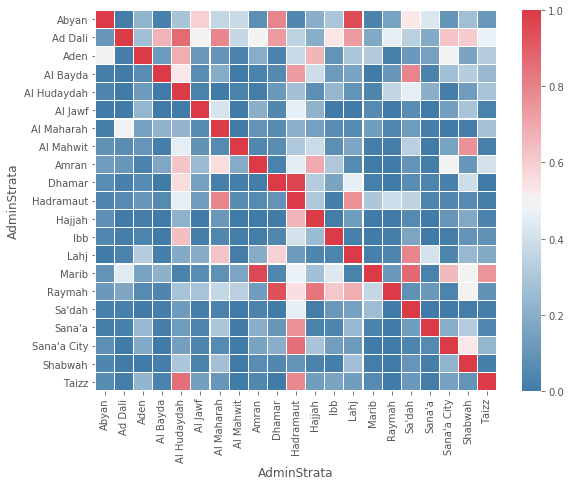

In [39]:
fig = plt.figure(figsize = (9, 7))
# Colors.
cmap = sns.diverging_palette(240, 10, as_cmap = True)
# Plotting the heatmap.
ax = sns.heatmap(G, linewidths = .1, cmap = cmap, xticklabels = G.columns, yticklabels = G.columns)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In the graph, if $G(X, Y) < 0.5$ then $Y$ Granger causes $X$, where $G(X, Y)$ is the p-value.